In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)

seed = 352 # set seed for reproducibility

df = pd.read_csv('Merged_SolarDataset.csv', sep = '\t', parse_dates=['timestamp'], index_col='timestamp')


In [2]:
df.describe()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
count,67092.000,68972.000,68972.000,68972.000,68972.000,68972.000,68972.000
mean,1.238,22.707,35.313,199.177,53.638,14.263,25.300
std,1.675,8.673,21.047,283.764,72.399,6.063,36.831
min,-0.004,-1.400,3.000,0.000,0.000,0.000,0.000
25%,0.000,16.300,19.000,0.000,0.000,10.000,0.000
50%,0.000,22.900,30.000,3.000,8.000,13.600,0.000
75%,2.636,29.200,47.000,394.250,94.000,18.100,46.000
max,5.758,45.100,100.000,1001.000,520.000,50.400,100.000


## Duplicate values in the daily interval

In [3]:
# daily dataset mask for subsetting
mask = (df.index.hour >= 7) & (df.index.hour <= 19)

day_dataset = df[mask]


duplicate_rows = day_dataset[day_dataset.duplicated()]
duplicate_rows

"""values seem to be with 0 active power; moreover, the meteorological data presents just one decimal, which increases the chances of duplicate values;
the duplicate values are valid, so they will not be removed"""

'values seem to be with 0 active power; moreover, the meteorological data presents just one decimal, which increases the chances of duplicate values;\nthe duplicate values are valid, so they will not be removed'

# Missing Values Analysis

<Axes: >

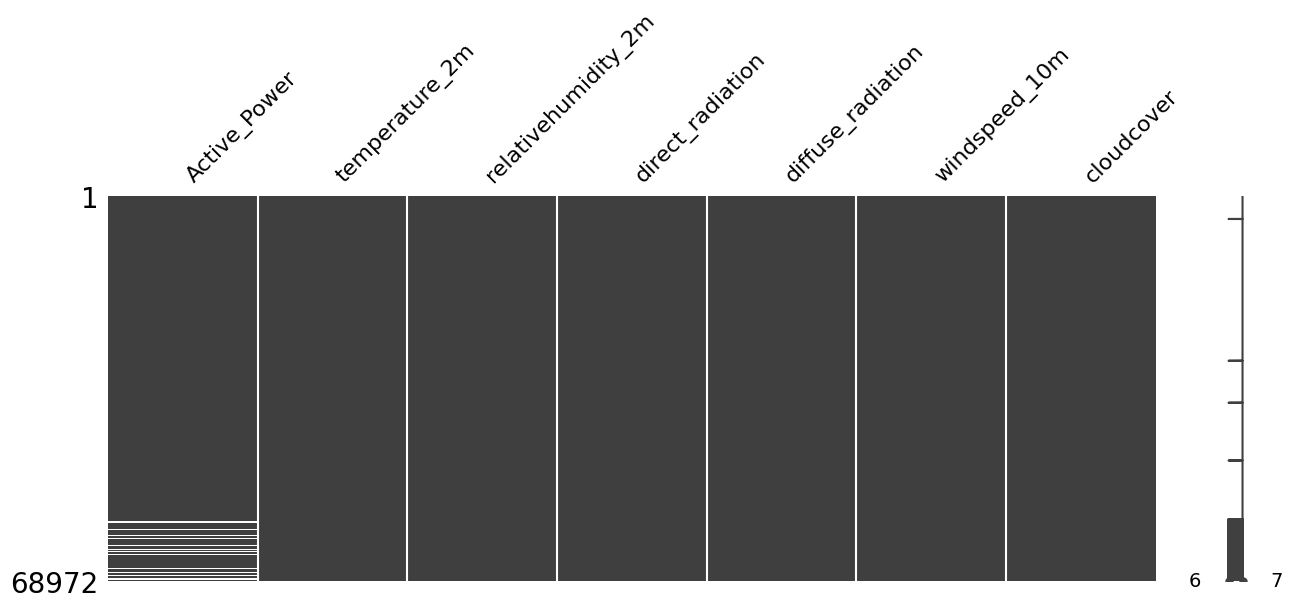

In [4]:
msno.matrix(df,  figsize=(15, 5))

### MICE imputation - Random Forest estimator

In [5]:

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

#initialize random forest estimator
rf = RandomForestRegressor(random_state= seed)

#initialize imputer
imputer = IterativeImputer(estimator = rf, max_iter = 10, random_state= seed)


#impute the missing values
imputed_data = imputer.fit_transform(df)

#save as dataframe
imputed_data_df = pd.DataFrame(imputed_data, columns = df.columns, index = df.index)

print(imputed_data_df.isna().sum())

Active_Power           0
temperature_2m         0
relativehumidity_2m    0
direct_radiation       0
diffuse_radiation      0
windspeed_10m          0
cloudcover             0
dtype: int64


### As energy generated can't be negative for the purposes of this study, negative imputed values will be set to 0

In [6]:
# set negative values to 0 
imputed_data_df['Active_Power'] = imputed_data_df['Active_Power'].clip(lower=0)

#check
imputed_data_df[imputed_data_df['Active_Power'] < 0 ]


,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,


### Mean and std of the feature before and after MICE imputation

In [7]:
mean_before = df['Active_Power'].mean()
std_before = df['Active_Power'].std()

print(f'Mean before MICE: {mean_before:.5f}')
print(f'Standard deviation before MICE: {std_before:.5f}')

mean_after = imputed_data_df['Active_Power'].mean()
std_after = imputed_data_df['Active_Power'].std()

print(f'Mean after MICE: {mean_after:.5f}')
print(f'Standard deviation after MICE: {std_after:.5f}')


Mean before MICE: 1.23819
Standard deviation before MICE: 1.67514
Mean after MICE: 1.24024
Standard deviation after MICE: 1.67401


# Outlier analysis

In [8]:

#the function can be called without print details, to only return a "Gaussian" or "Not Gaussian" string, or can be called with extensive details with print_details = True
def check_gaussian_distribution(dataframe, attribute, alpha, print_details = False):

	"""The purposes of this function is to check if a features' distribution follows a Gaussian distribution.
	Each test looks at the question of whether a sample was drawn from a Gaussian distribution from a slightly different perspective.
	The Shapiro-Wilk test is believed to be a reliable test of normality, although there is some suggestion that the test may be suitable for smaller samples of data
	The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, to determine if the data distribution departs from the normal distribution
	Anderson-Darling Test can be used to check whether a data sample is normal;it is a modified version of the more sophisticated nonparametric goodness-of-fit statistical test Kolmogorov-Smirnov
	A feature of the Anderson-Darling test is that it returns a list of critical values rather than a single p-value. This can provide the basis for a more thorough interpretation of the result."""
		


	from scipy.stats import shapiro
	from scipy.stats import normaltest
	from scipy.stats import anderson

	data = dataframe[attribute].values
	shapirostat, p = shapiro(data)
	k2stat, l = normaltest(data)
	result = anderson(data)

	for i in range(len(result.critical_values)):
		sl, cv = result.significance_level[i], result.critical_values[i]
	if (print_details == True):
		print("🟢🟢🟢🟢🟢 Normality Tests 🟢🟢🟢🟢🟢")
		print("H0: variable follows a Gaussian distribution\nH1: variable does not follow a Gaussian distribution" )
		print("------------------------------------------")
		print('Shapiro Statistics=%.3f, p=%.3f' % (shapirostat, p))
		if p > alpha:
			print('Shapiro test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('Shapiro test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('K^2 Statistics=%.3f, p=%.3f' % (k2stat, l))
		if l > alpha:
			print('K^2 test: Sample looks Gaussian (fail to reject H0)')
		else:
			print('K^2 test: Sample does not look Gaussian (reject H0)')
		print("------------------------------------------")
		print('Anderson-Darling Statistic: %.3f' % result.statistic)

		if result.statistic < result.critical_values[i]:
			print('%.3f: %.3f, data looks normal from an Anderson-Darling perspective (fail to reject H0)' % (sl, cv))
		else:
			print('%.3f: %.3f, data does not look normal from an Anderson-Darling perspective (reject H0)' % (sl, cv))
		print("------------------------------------------")
		if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i]) ):
			print("All of the normality tests conclude that the attribute " + attribute + " is extracted from a Gaussian distribution")
		
		else:
			print("At least 1 of the normality tests indicate that the attribute " + attribute + " does not follow a Gaussian distribution")
		
	
	#Critical values in a statistical test are a range of pre-defined significance boundaries at which the H0 can be failed to be rejected if
	# the calculated statistic is less than the critical value. 
	# Rather than just a single p-value, the test returns a critical value for a range of different commonly used significance levels.
	if ((p>alpha) & (l> alpha) & (result.statistic < result.critical_values[i])):
		return "Gaussian"
	else:
		return "Not Gaussian"
	

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column Active_Power: 0


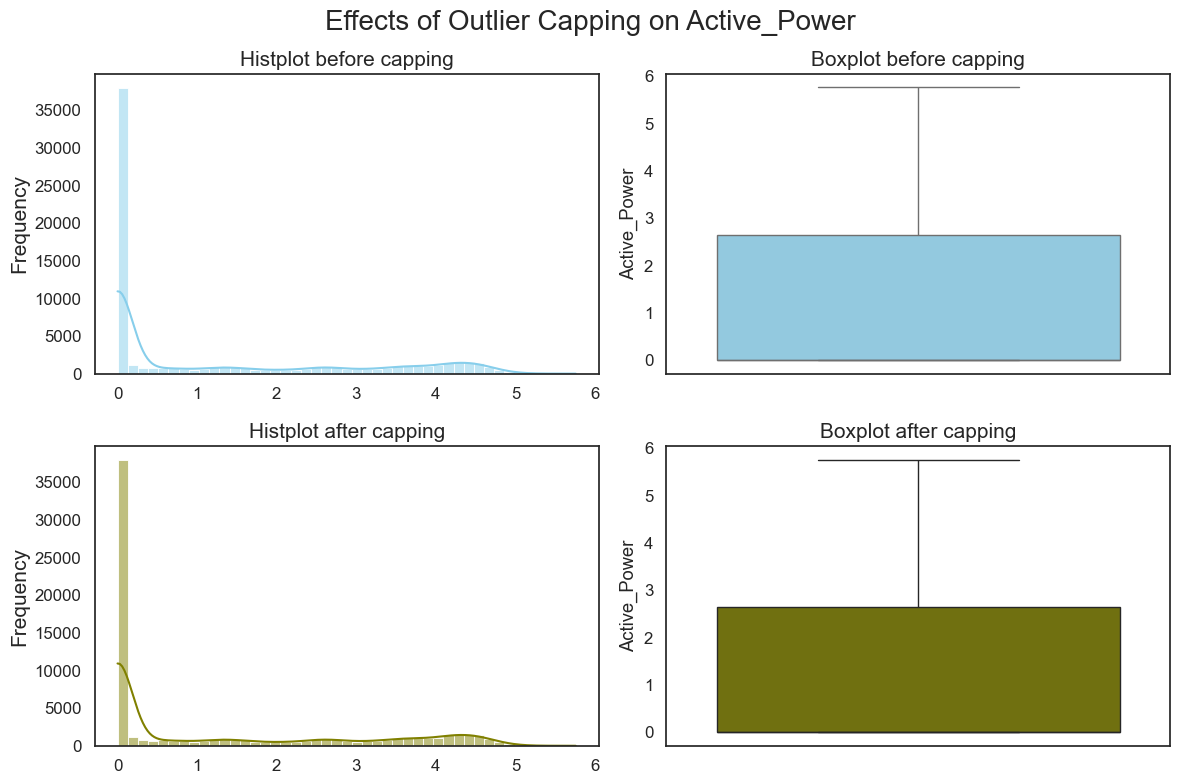

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column temperature_2m: 0


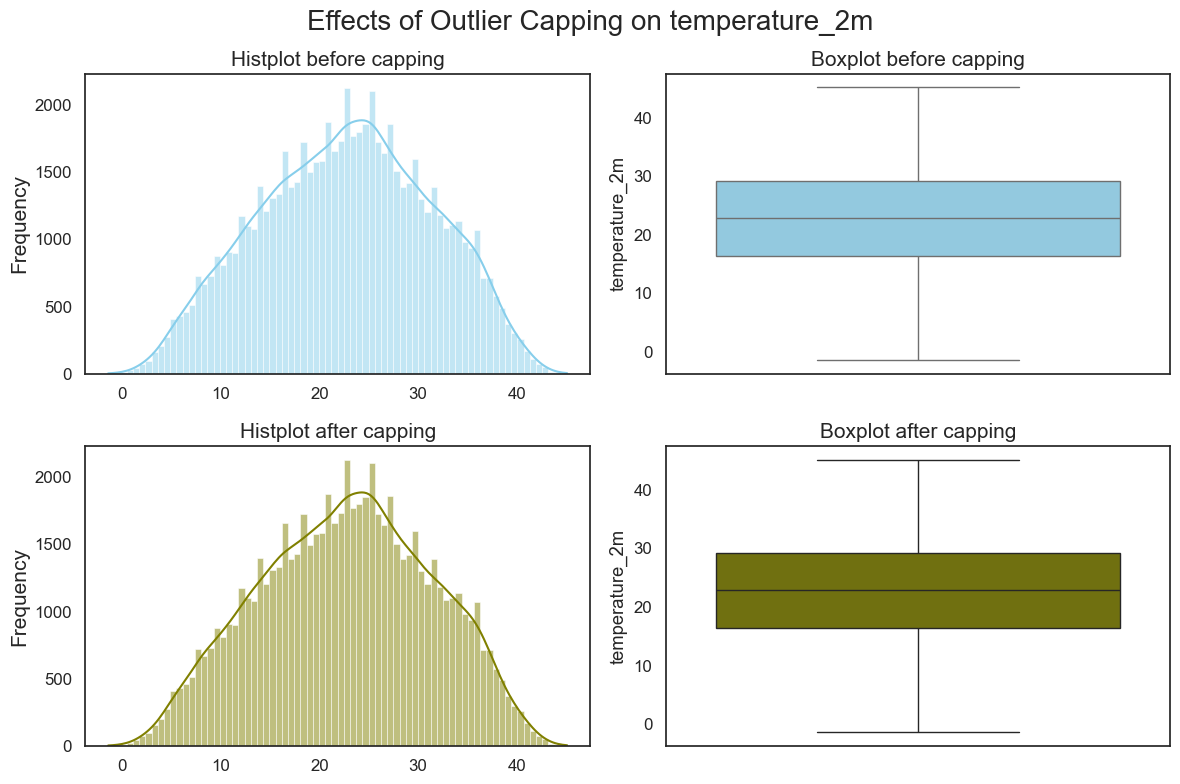

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column relativehumidity_2m: 1138


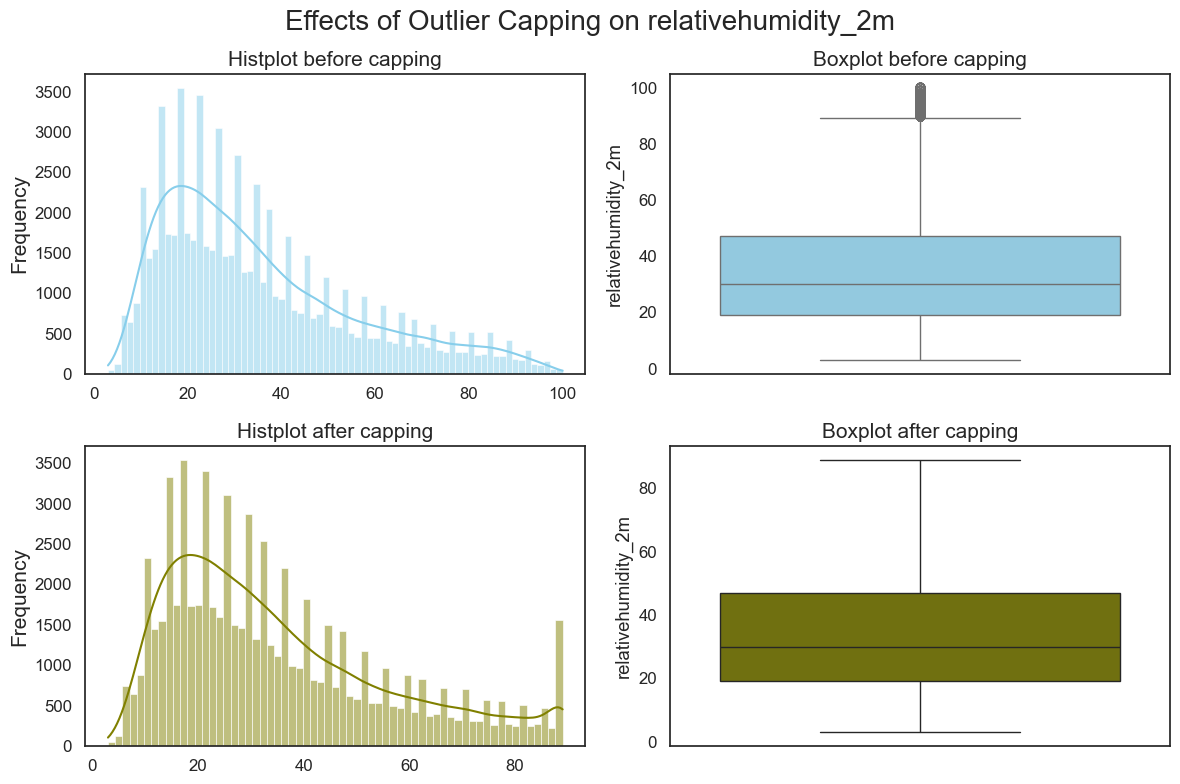

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column direct_radiation: 24


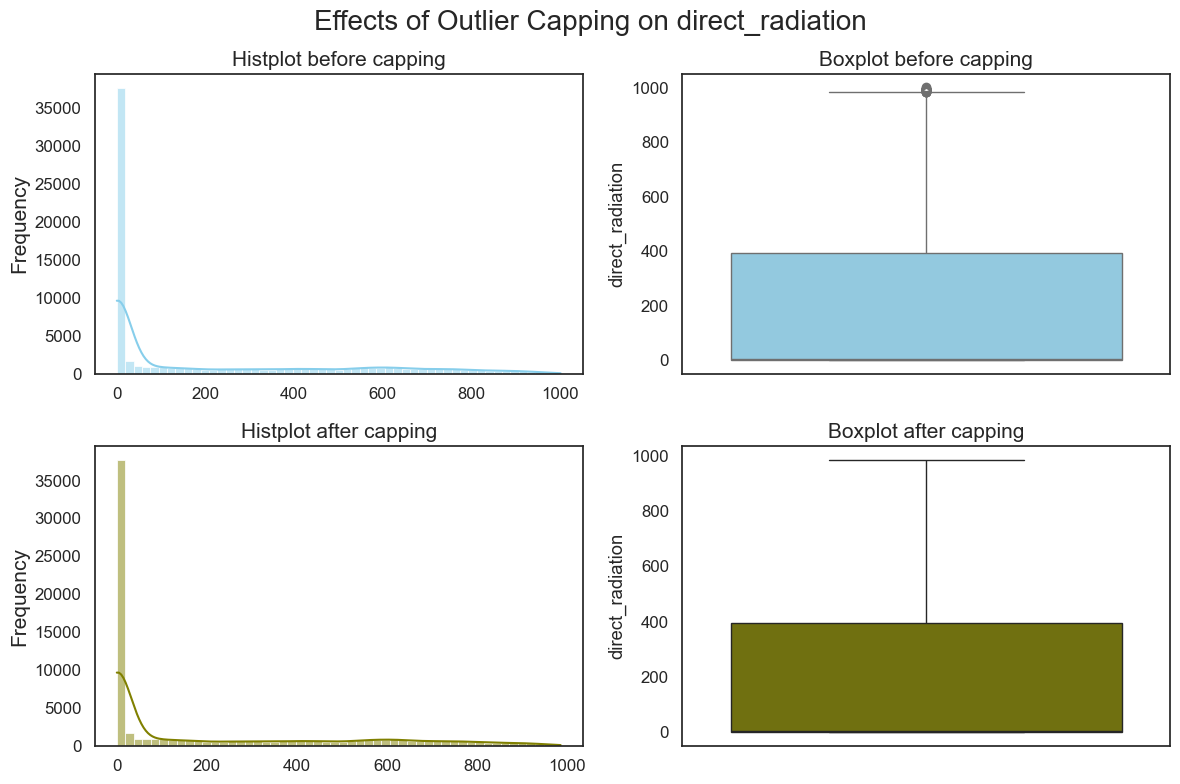

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column diffuse_radiation: 2030


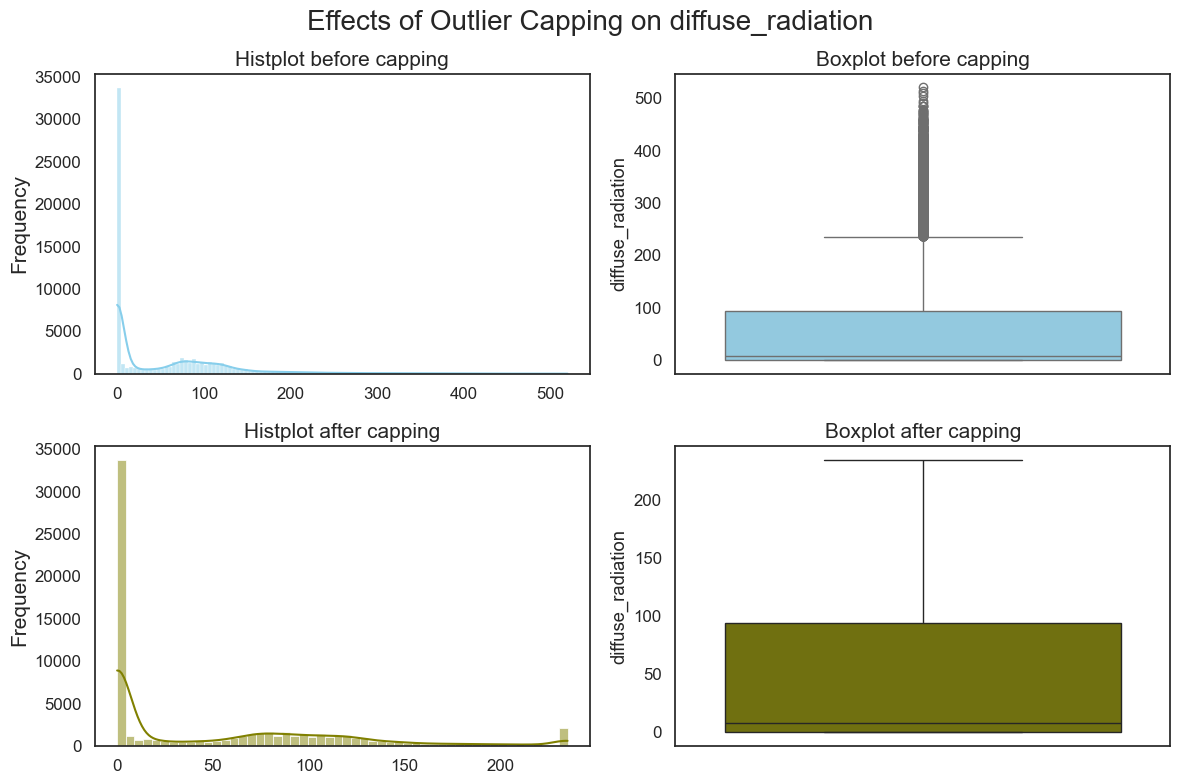

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column windspeed_10m: 658


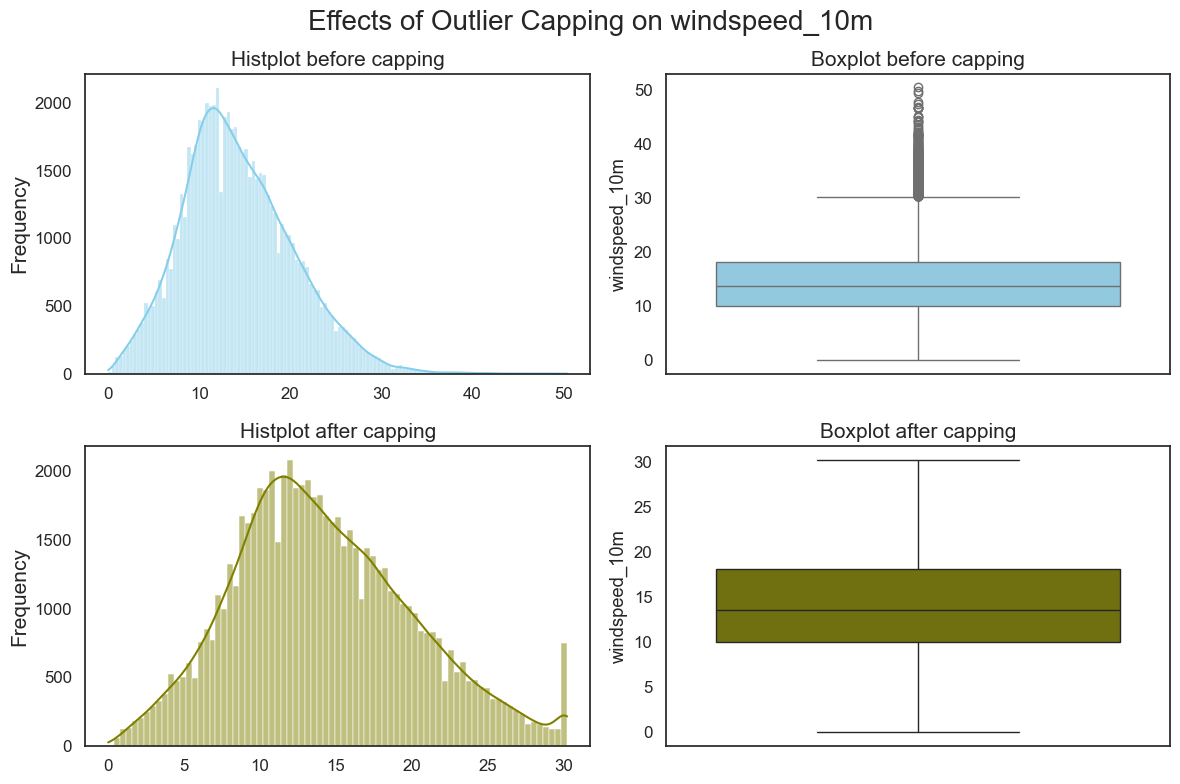

/Users/syrine/Desktop/SOLAR ENERGY FORECASTING-NOVAERA/solarvenv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 68972.
  res = hypotest_fun_out(*samples, **kwds)


The number of values replaced in column cloudcover: 0


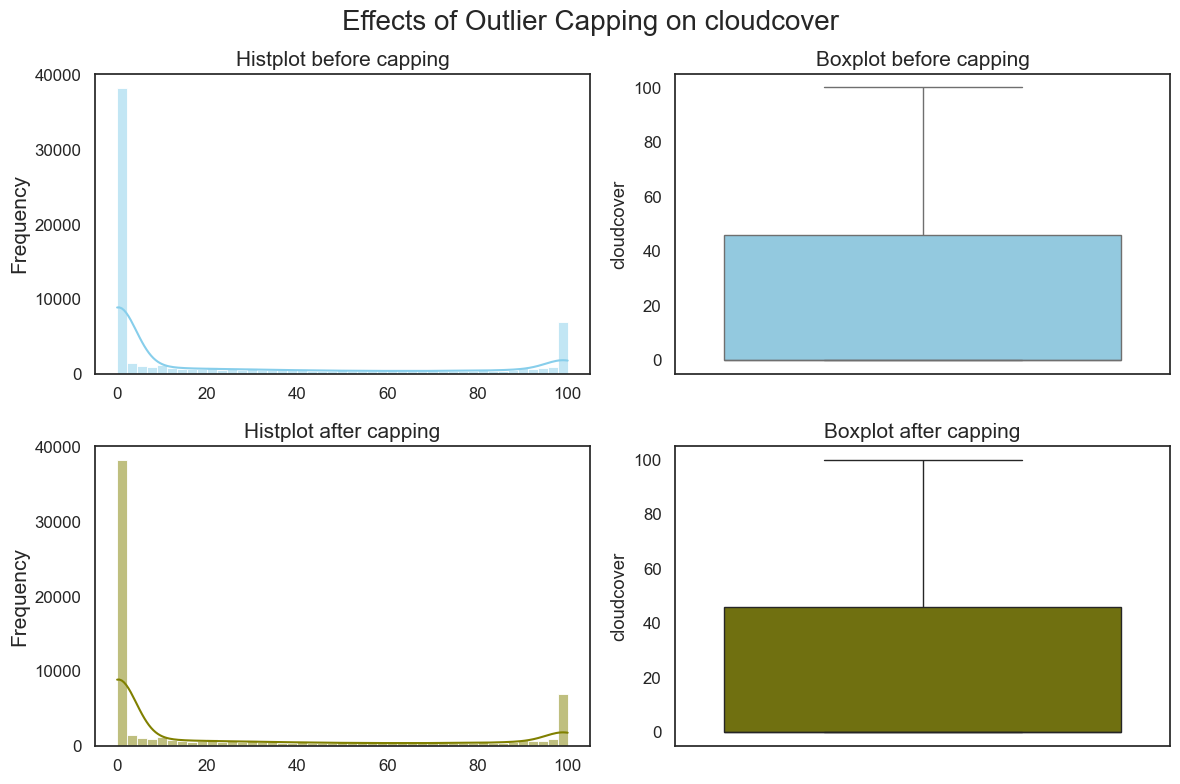

In [9]:
sns.set(style='white',palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 5]})

#the following function will clean the data of outliers by using capping, if they exist, and plot the histogram and boxplot before and after
def cap_outliers(df):
    #normal distribution: The data points which fall below mean-3*(sigma) or above mean+3*(sigma) are outliers; 
    #skewed distribution: The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

    new_df_cap = df.copy()
    for col in new_df_cap.columns:
        varcheck = check_gaussian_distribution(df, col, 0.05)
        if varcheck == "Not Gaussian":   
            percentile25 = df[col].quantile(0.25)
            percentile75 = df[col].quantile(0.75)
            IQR = percentile75 - percentile25

            upper_limit = percentile75 + 1.5 * IQR
            lower_limit = percentile25 - 1.5 * IQR
            

            old_values = new_df_cap[col].copy()
            new_df_cap[col] = np.where(
                new_df_cap[col] > upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col] < lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
                # Count the number of values that were replaced
            count = np.sum(old_values != new_df_cap[col])

            print(f"The number of values replaced in column {col}: {count}")
        else:  #if the variable follows a normal distribution
            upper_limit = new_df_cap[col].mean() + 3*df[col].std()
            lower_limit = new_df_cap[col].mean() - 3*df[col].std()
            new_df_cap[col] = np.where(
                new_df_cap[col]>upper_limit,
                upper_limit,
                np.where(
                    new_df_cap[col]<lower_limit,
                    lower_limit,
                    new_df_cap[col]
                        )
                )
            



        plt.figure(figsize=(12,8))

        plt.suptitle('Effects of Outlier Capping on ' + str(col), fontsize=20)

        plt.subplot(2,2,1)
        sns.histplot(df[col], color="skyblue", kde=True).set(xlabel=None)
        plt.title('Histplot before capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        

        plt.subplot(2,2,2)
        sns.boxplot(df[col], color="skyblue")
        plt.title('Boxplot before capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        

        plt.subplot(2,2,3)
        sns.histplot(new_df_cap[col], color="olive", kde=True).set(xlabel=None)
        plt.title('Histplot after capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        plt.ylabel('Frequency', fontsize=15)
        

        plt.subplot(2,2,4)
        sns.boxplot(new_df_cap[col], color="olive")
        plt.title('Boxplot after capping', fontsize=15)
        #plt.xlabel(str(col), fontsize=15)
        

        plt.tight_layout()
        plt.subplots_adjust(top=0.90)
        plt.show()





    return new_df_cap

transformed_df = cap_outliers(imputed_data_df)


### Saving the dataframe with missing values imputed and outliers capped

In [11]:
transformed_df.to_csv('Full_SolarDataset.csv', sep = '\t')

# Post-Processing Analysis

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np


df = pd.read_csv('Full_SolarDataset.csv', sep = '\t', parse_dates=['timestamp'], index_col='timestamp')

df.head()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,
2017-01-20 00:00:00,0.000,26.800,72.000,0.000,0.000,21.300,0.000
2017-01-20 01:00:00,0.000,26.200,75.000,0.000,0.000,20.900,6.000
2017-01-20 02:00:00,0.000,25.700,78.000,0.000,0.000,20.400,5.000
2017-01-20 03:00:00,0.000,25.300,80.000,0.000,0.000,19.100,12.000
2017-01-20 04:00:00,0.000,25.000,81.000,0.000,0.000,19.100,18.000


In [13]:
df.describe()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
count,68972.000,68972.000,68972.000,68972.000,68972.000,68972.000,68972.000
mean,1.240,22.707,35.240,199.175,51.565,14.230,25.300
std,1.674,8.673,20.848,283.758,65.144,5.955,36.831
min,0.000,-1.400,3.000,0.000,0.000,0.000,0.000
25%,0.000,16.300,19.000,0.000,0.000,10.000,0.000
50%,0.000,22.900,30.000,3.000,8.000,13.600,0.000
75%,2.638,29.200,47.000,394.250,94.000,18.100,46.000
max,5.758,45.100,89.000,985.625,235.000,30.250,100.000


## Multicollinearity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X, thresh=5.0):
    """
    This function calculates the Variance Inflation Factor (VIF) for each feature in a dataframe. 
    It returns a dataframe with the VIF values.
    """
    # Calculate VIF for each feature
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

def highlight_VIF(series):
    """ 
    This functions highlights VIF values over 10 in red, between 5 and 10 in yellow, and under 5 in green.
    """
    green = 'color: lightgreen'
    yellow = 'color: yellow'
    red = 'color: red'
    return [green if value <= 5 else yellow if value <10 else red for value in series]

VIF_Predictors = ['temperature_2m', 
                  'relativehumidity_2m', 
                  'cloudcover',
                  'direct_radiation', 
                  'diffuse_radiation',
                  'windspeed_10m']


vif_table = calculate_vif(df[VIF_Predictors]).style.apply(highlight_VIF, subset=['VIF'])

vif_table

,feature,VIF
0,temperature_2m,7.004327
1,relativehumidity_2m,2.660227
2,cloudcover,2.055995
3,direct_radiation,3.888749
4,diffuse_radiation,4.193391
5,windspeed_10m,6.289358


## Correlation matrix

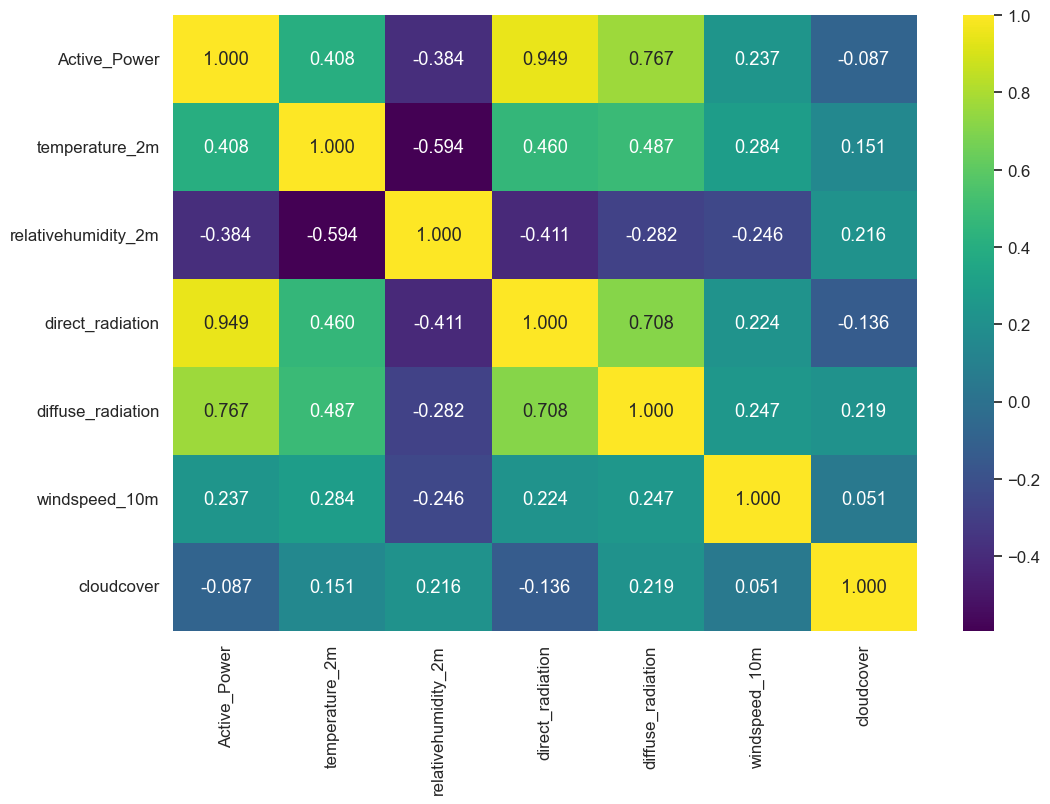

In [15]:
corr = df.corr()
fig,ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.3f')
plt.show()

## Resampling the dataset to daily frequency

In [16]:
df_resampled = df.resample('D').mean()  # Change 'D' to 'M' for monthly data

df_resampled.head()

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover
timestamp,,,,,,,
2017-01-20,1.439,29.979,59.083,212.250,71.250,16.475,32.875
2017-01-21,1.098,29.500,60.125,147.833,76.667,8.021,66.500
2017-01-22,1.048,28.933,65.833,206.625,78.083,11.600,68.958
2017-01-23,1.115,27.188,72.792,115.583,86.958,12.800,84.208
2017-01-24,0.737,26.854,77.458,185.333,72.625,9.804,67.625


## Evolution of solar energy power

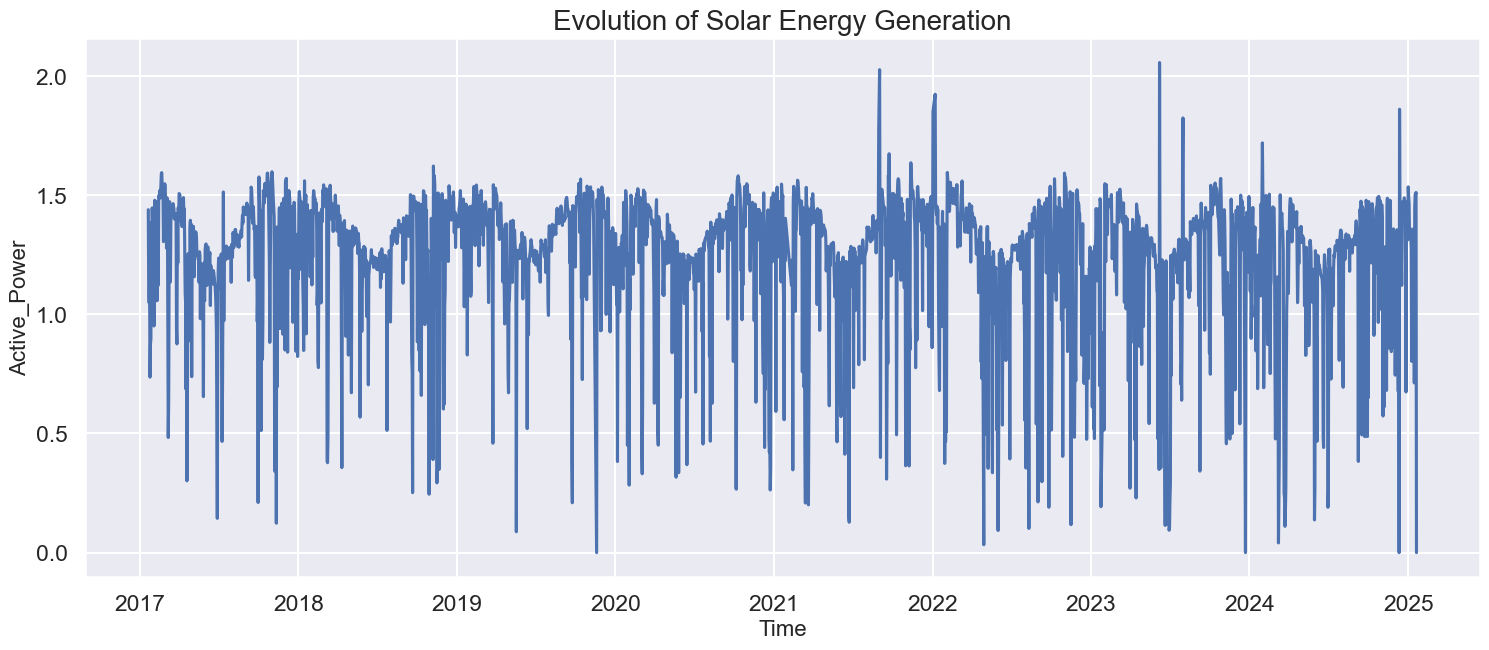

In [17]:
# Setting the overall aesthetic.
sns.set(style="darkgrid")
# Set the size and context of the plot
sns.set(rc={'figure.figsize':(18,7)})
sns.set_context("talk")

feature = 'Active_Power'
# Create the line plot
sns.lineplot(x=df_resampled.index, y=df_resampled[feature])

plt.title('Evolution of Solar Energy Generation', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Active_Power', fontsize=16)

# Show the plot
plt.show()

## Joint distribution of pairs of features

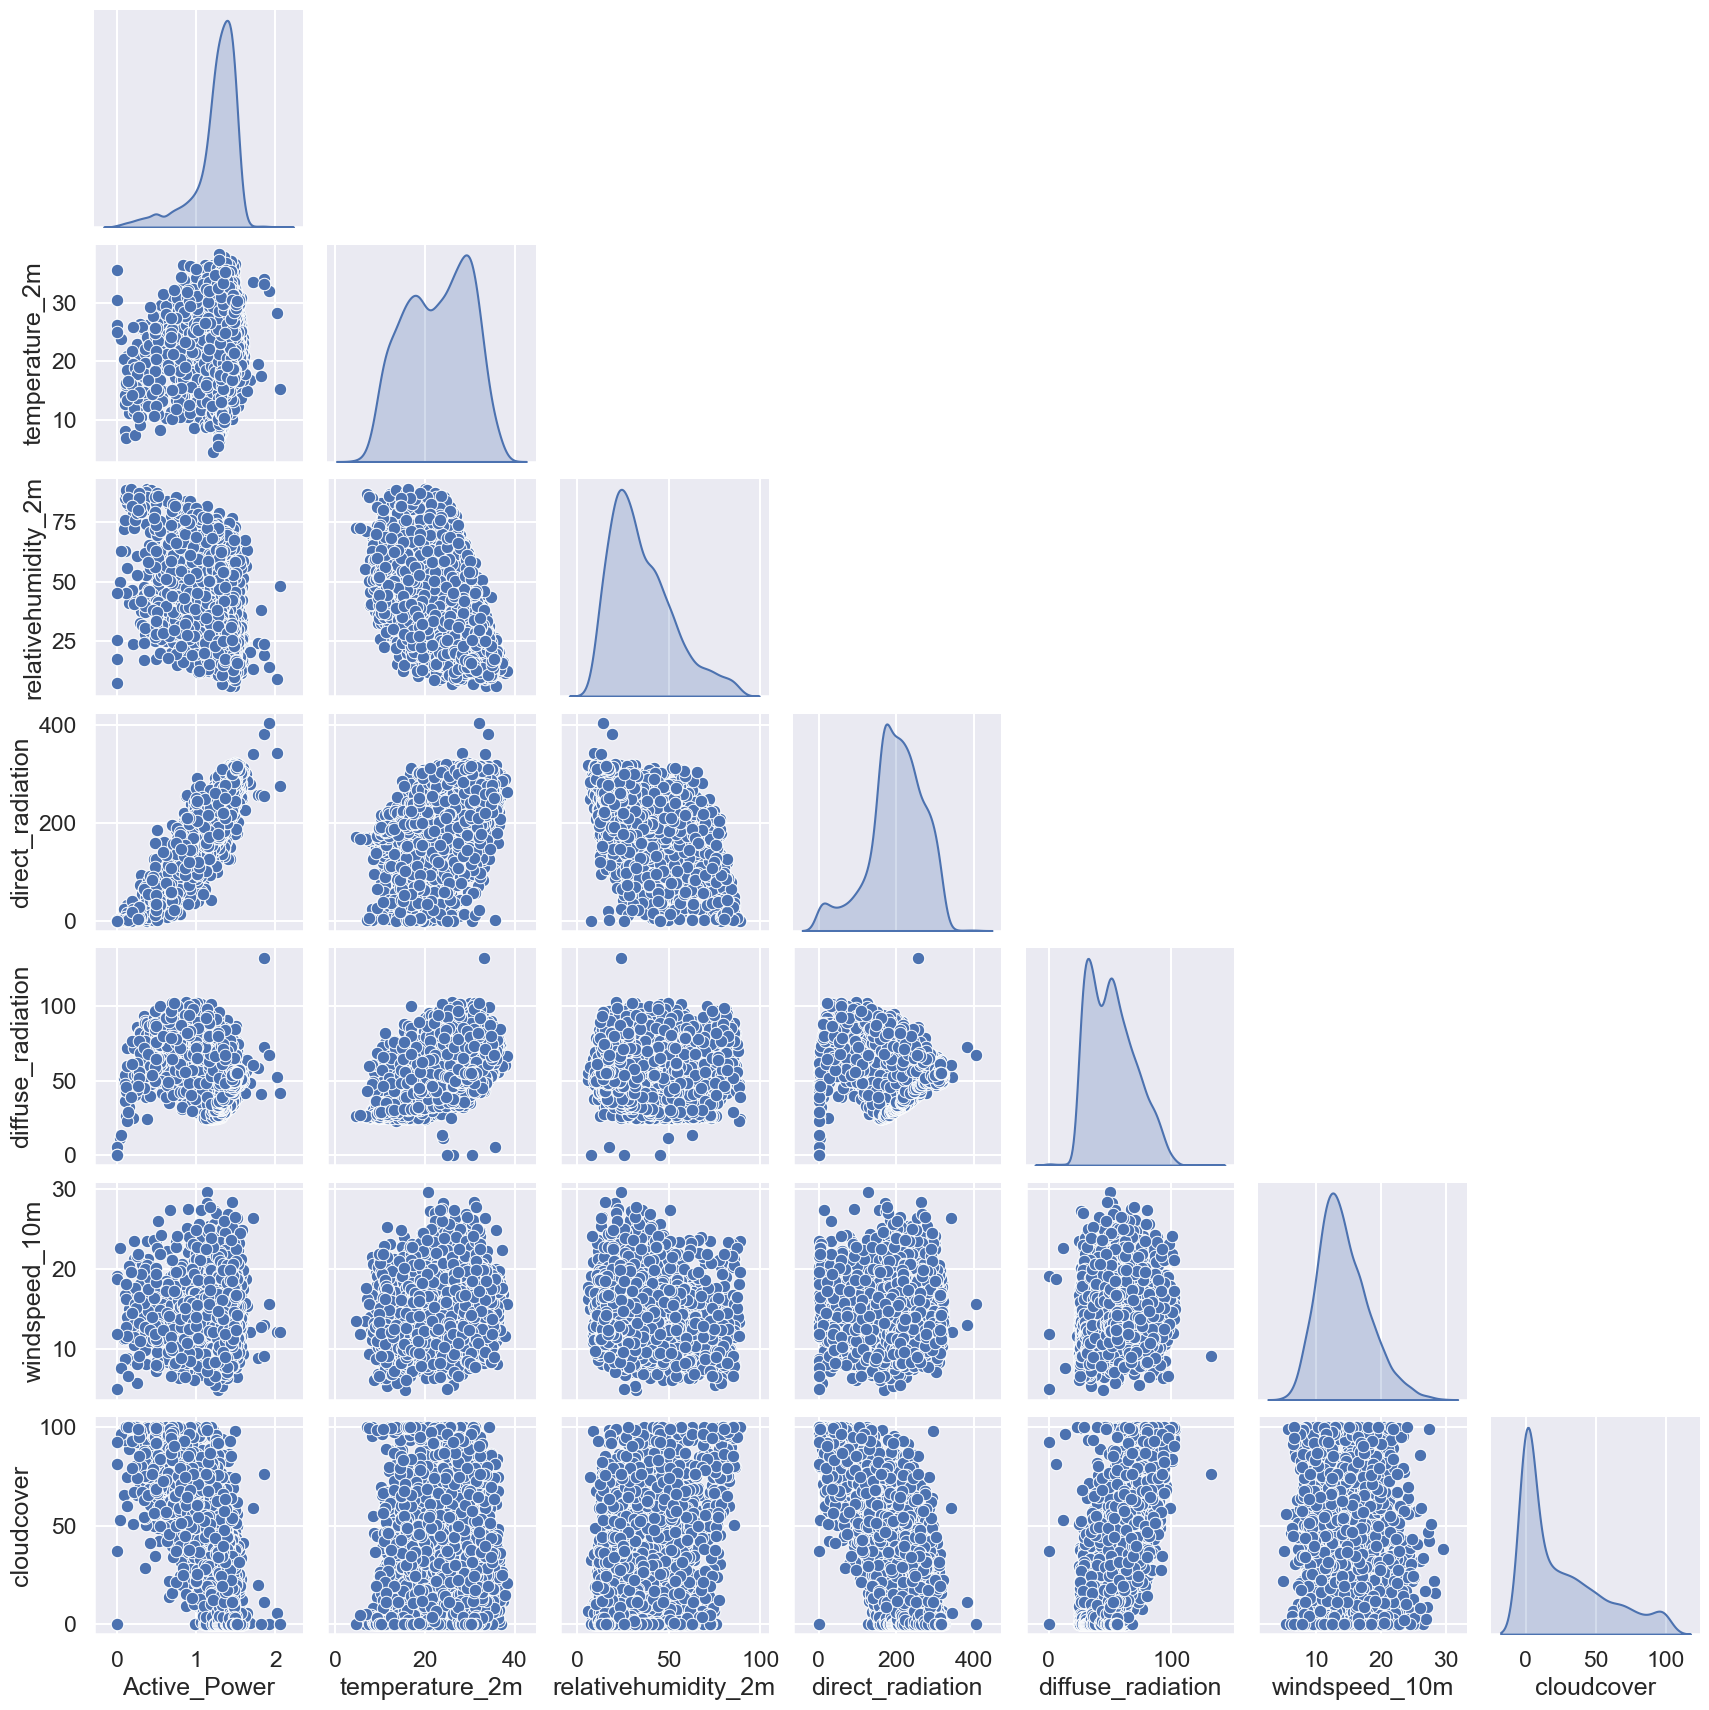

In [18]:
sns.pairplot(df_resampled, diag_kind='kde', corner = True)

## Add season & month to dataset

In [19]:
## Create a season and month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'


df_resampled['season'] = df_resampled.index.month.map(get_season)
# Create 'month' column
df_resampled['month'] = df_resampled.index.month_name()

df_resampled

,Active_Power,temperature_2m,relativehumidity_2m,direct_radiation,diffuse_radiation,windspeed_10m,cloudcover,season,month
timestamp,,,,,,,,,
2017-01-20,1.439,29.979,59.083,212.250,71.250,16.475,32.875,Winter,January
2017-01-21,1.098,29.500,60.125,147.833,76.667,8.021,66.500,Winter,January
2017-01-22,1.048,28.933,65.833,206.625,78.083,11.600,68.958,Winter,January
2017-01-23,1.115,27.188,72.792,115.583,86.958,12.800,84.208,Winter,January
2017-01-24,0.737,26.854,77.458,185.333,72.625,9.804,67.625,Winter,January
...,...,...,...,...,...,...,...,...,...
2025-01-16,1.449,30.396,25.542,299.708,54.167,18.504,0.000,Winter,January
2025-01-17,1.504,29.012,17.083,311.333,54.958,16.700,0.000,Winter,January
2025-01-18,1.503,29.817,16.917,311.875,54.875,12.400,0.000,Winter,January


## KDE plots

### Seasonal view

Text(0.5, 1.0, 'Kernel Density Estimation of Active Power by Season')

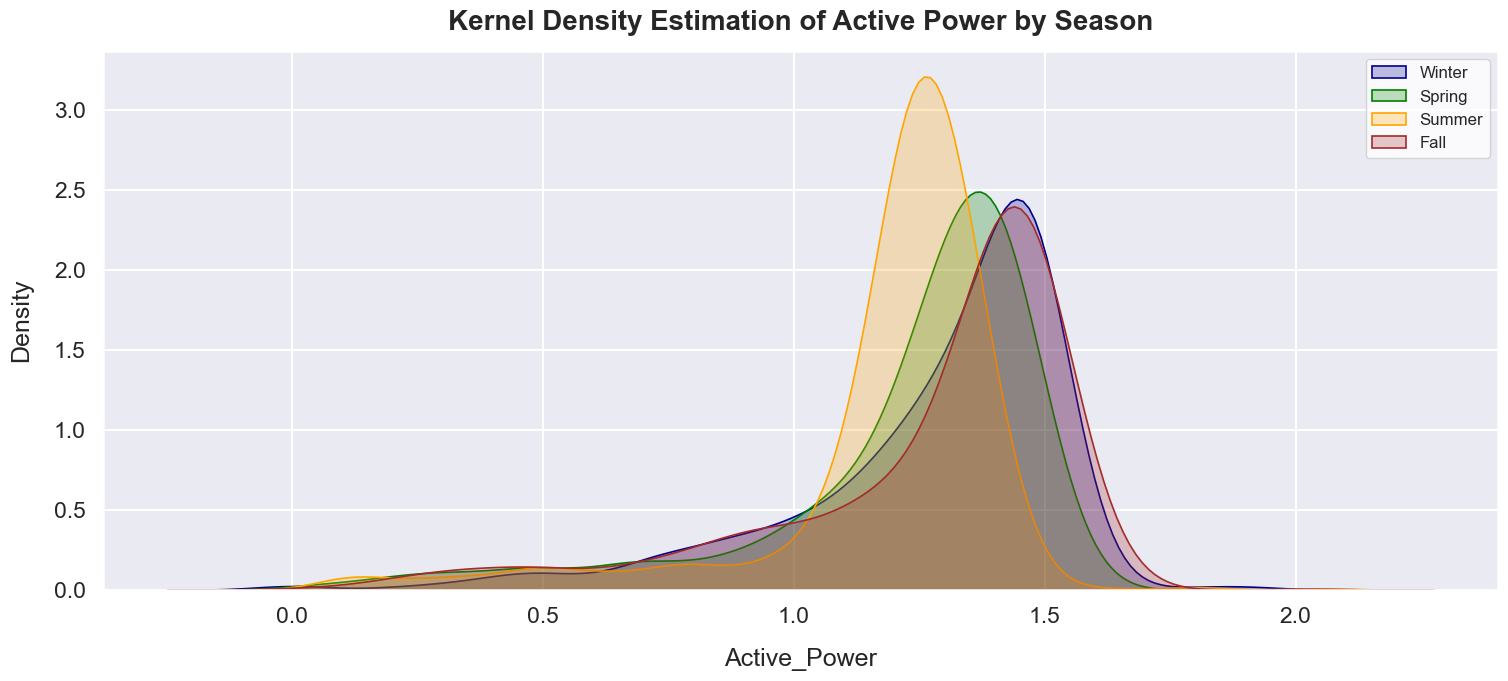

In [20]:
fig, ax = plt.subplots()

sns.set(style='whitegrid',palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 8]})

colors = {"Winter": "darkblue", "Spring": "green", "Summer": "orange", "Fall": "brown"}

for season, color in colors.items():
    sns.kdeplot(df_resampled[df_resampled["season"]==season]["Active_Power"], 
                fill=True, 
                color=color, 
                label=season, 
                ax=ax,
                linewidth=1.2)
ax.legend()
ax.set_xlabel("Active_Power", labelpad=15)
ax.set_ylabel("Density", labelpad=15)
ax.set_title('Kernel Density Estimation of Active Power by Season', pad=15, fontsize = 20, fontweight = 'bold')


### Monthly view


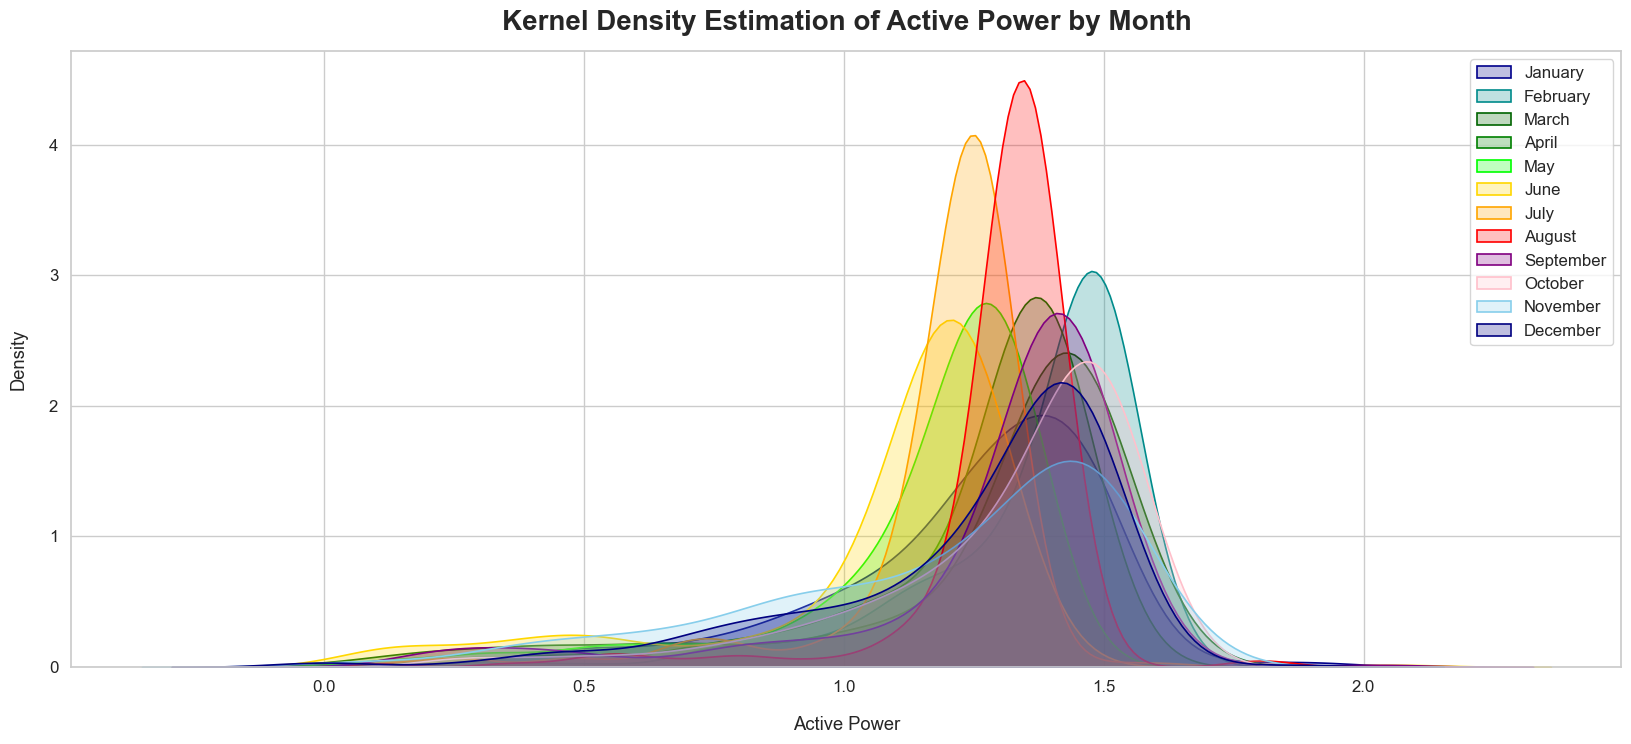

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

sns.set(style='whitegrid',palette="deep", font_scale=1.1, rc={"figure.figsize": [20, 8]})

# Define a color palette with distinct colors for each month
colors = {"January": "darkblue", "February": "darkcyan", "March": "darkgreen", 
          "April": "green", "May": "lime", "June": "gold",
          "July": "orange", "August": "red", "September": "purple",
          "October": "pink", "November": "skyblue", "December": "navy"}

for month, color in colors.items():
    sns.kdeplot(df_resampled[df_resampled["month"]==month]["Active_Power"], 
                fill=True, 
                color=color, 
                label=month, 
                ax=ax,
                linewidth=1.2)

ax.legend()
ax.set_xlabel("Active Power", labelpad=15)
ax.set_ylabel("Density", labelpad=15)
ax.set_title('Kernel Density Estimation of Active Power by Month', pad=15, fontsize = 20, fontweight = 'bold')

plt.show()

### Histplots

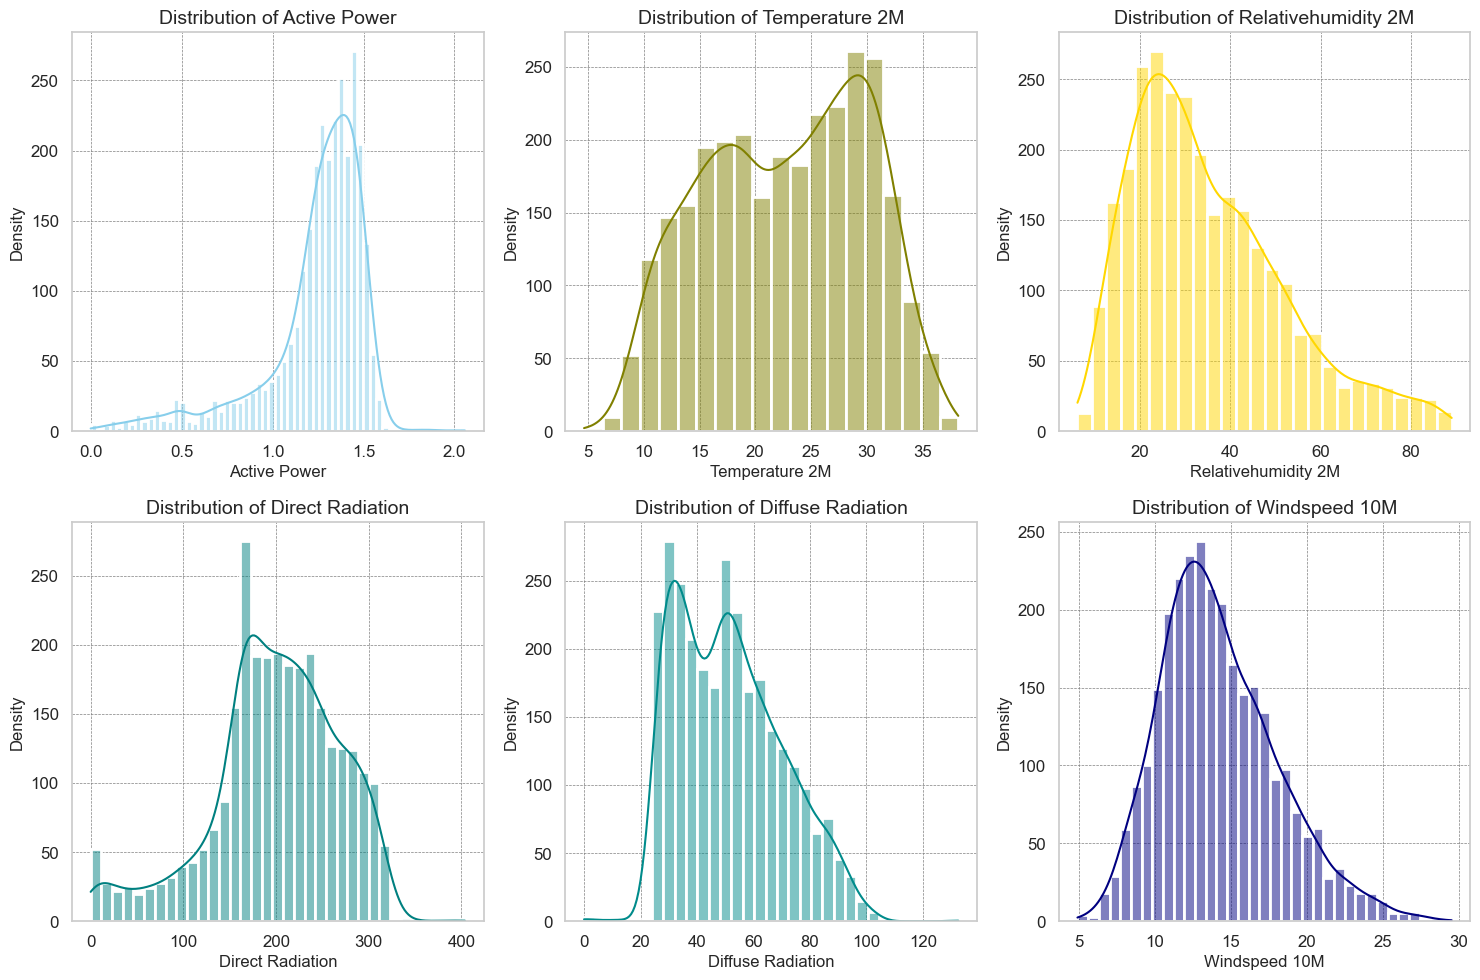

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Define the names and colors for your plots
variables = [
    ("Active_Power", "skyblue"),
    ("temperature_2m", "olive"),
    ("relativehumidity_2m", "gold"),
    ("direct_radiation", "teal"),
    ("diffuse_radiation", "darkcyan"),
    ("windspeed_10m", "navy"),
]

# Create the plots
for ax, (var, color) in zip(axs.flatten(), variables):
    sns.histplot(data=df_resampled, x=var, kde=True, color=color, ax=ax, linewidth=2)
    ax.set_title(f'Distribution of {var.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel(var.replace("_", " ").title(), fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()

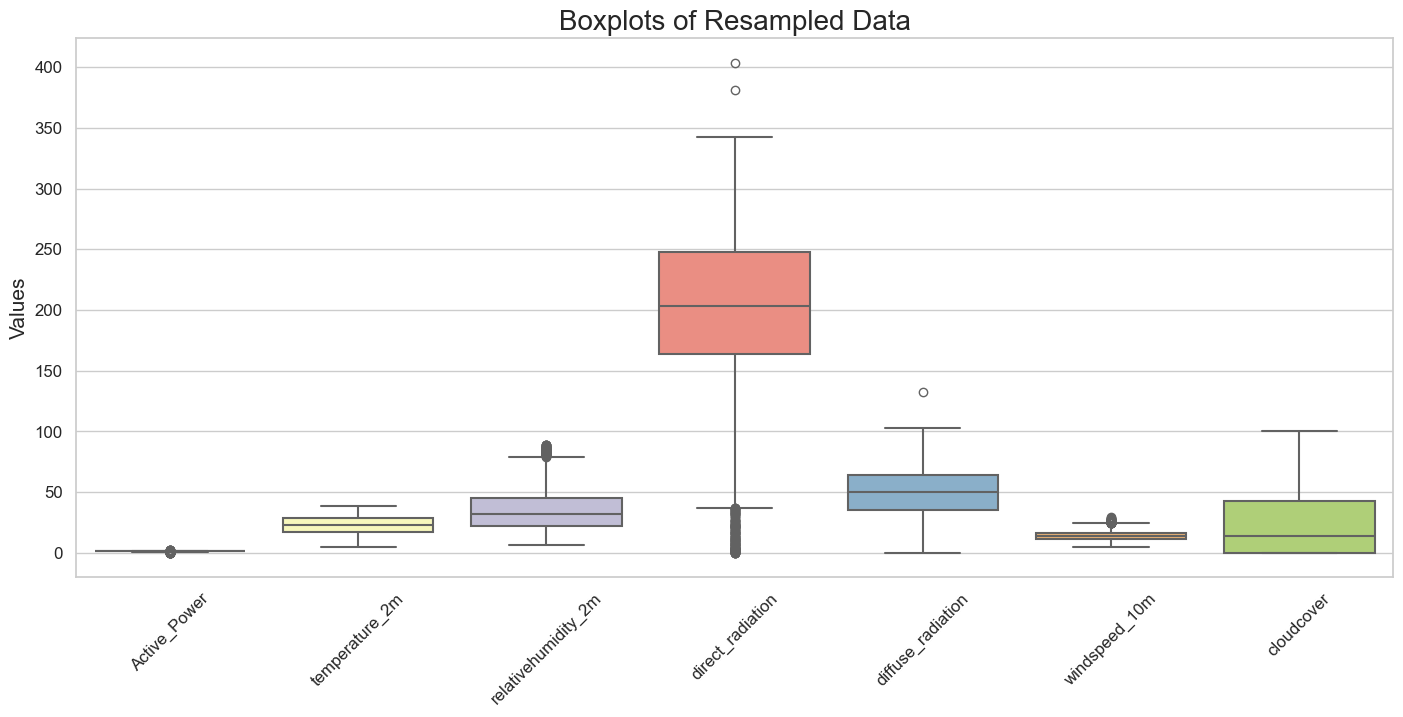

In [23]:
fig, ax = plt.subplots(figsize=(17, 7))

# Set a style for seaborn plots
sns.set(style="whitegrid")

# Create the boxplot, using a color palette to provide some variation in colors
sns.boxplot(data=df_resampled, palette="Set3", linewidth=1.5)

# Set the title, label for the y-axis
ax.set_title('Boxplots of Resampled Data', fontsize=20)
ax.set_ylabel('Values', fontsize=15)

# Rotate x labels for better readability, adjust according to your needs
plt.xticks(rotation=45)

plt.show()